In [1]:
# http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

# 需要处理为HDF5格式的数据集

In [2]:
# https://github.com/makeyourownneuralnetwork/gan/blob/master/10_celeba_download_make_hdf5.ipynb
#import torchvision.datasets
#mnist_dataset = torchvision.datasets.CelebA(root='.', download=True)

# the above codes cost a lot time, so I do not use this


In [3]:
def crop_centre(img, cropx, cropy):
    y, x, c = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty + cropy, startx:startx + cropx, :]

In [4]:
import h5py
import zipfile
import imageio
import os

#%%time

img_folder  = r"C:\projects\study-deep-learning\gan\CelebA\Img"

# location of the HDF5 package, yours may be under /gan/ not /myo_gan/
hdf5_file = os.path.join(img_folder, 'celeba_aligned_small.h5py') 

if os.path.exists(hdf5_file):
    print(f"already exists: {hdf5_file}")
else:
    img_align_zip = os.path.join(img_folder, 'img_align_celeba.zip')

    # how many of the 202,599 images to extract and package into HDF5
    total_images = 20000

    with h5py.File(hdf5_file, 'w') as hf:

        count = 0

        with zipfile.ZipFile(img_align_zip, 'r') as zf:
            for i in zf.namelist():
                if (i[-4:] == '.jpg'):
                    # extract image
                    ofile = zf.extract(i)
                    img = imageio.imread(ofile)
                    os.remove(ofile)
                    # add image data to HDF5 file with new name
                    hf.create_dataset('img_align_celeba/'+str(count)+'.jpg', data=img, compression="gzip", compression_opts=9)
                    count = count + 1
                    if (count%1000 == 0):
                        print("images done .. ", count)
                    # stop when total_images reached
                    if (count == total_images):
                        break

already exists: C:\projects\study-deep-learning\gan\CelebA\Img\celeba_aligned_small.h5py


In [5]:
# let get more information about hdf5 file
with h5py.File(hdf5_file, 'r') as hf:
    print(hf.keys())
    print(hf['img_align_celeba/0.jpg'])
    for group in hf:
        print(group)


<KeysViewHDF5 ['img_align_celeba']>
<HDF5 dataset "0.jpg": shape (218, 178, 3), type "|u1">
img_align_celeba


In [6]:
import matplotlib.pyplot as plt
import numpy as np


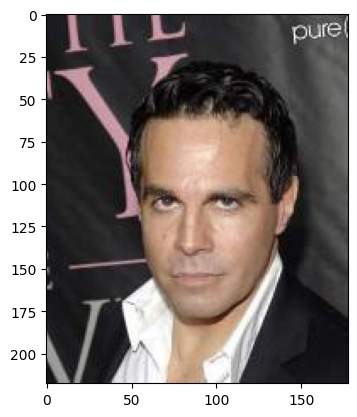

In [7]:
with h5py.File(hdf5_file, "r") as hf:
    dataset = hf['img_align_celeba']
    image_7 = dataset['7.jpg']
    plt.imshow(image_7)

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas as pd

c:\Users\ben7276\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
class CelebAdataset(Dataset):
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if index >= len(self.dataset):
            raise IndexError
        img = np.array(self.dataset[str(index)+'.jpg']) 
        img = crop_centre(img, 128, 128)
        return torch.cuda.FloatTensor(img).permute(2,0,1).view(1,3,128,128) / 255.0

    def plot_image(self, index):
        if index >= len(self.dataset):
            raise IndexError
        img = np.array(self.dataset[str(index)+'.jpg']) 
        img = crop_centre(img, 128, 128)
        plt.imshow(img, interpolation='nearest')

20000


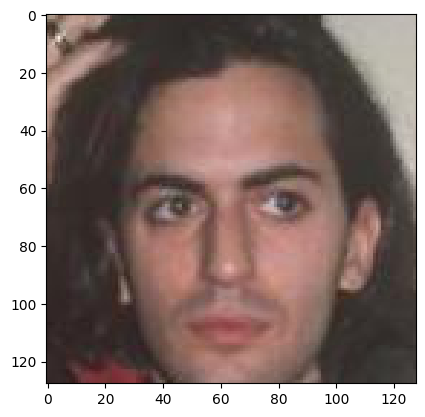

In [10]:
celeba_dataset = CelebAdataset(hdf5_file)
print(len(celeba_dataset))
celeba_dataset.plot_image(2000)

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [12]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # define the network
        self.model = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.Conv2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 3, kernel_size=8, stride=2),
            nn.LeakyReLU(0.2),

            View(3*10*10),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid()
        )

        # define the loss function
        self.loss_function = nn.MSELoss()

        # define the optimiser
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # define the counter
        self.count = 0
        self.progress = []



    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        self.count += 1

        if self.count % 10 == 0:
            self.progress.append(loss.item())

            if self.count % 1000 == 0:
                print("counter = ", self.count)

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))

In [13]:
def generate_random_image():
    # return gpu tensor
    return torch.rand(218, 178, 3).to(device)

x = generate_random_image()
x.device

device(type='cuda', index=0)

In [28]:
def generate_random_image(size):
    random_data = torch.rand(size).to(device)
    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size).to(device)
    return random_data

x = generate_random_image((1, 3, 128, 128))
#x.device
x
#y = generate_random_seed((1, 100))
#y.device

tensor([[[[0.1379, 0.3147, 0.0610,  ..., 0.4042, 0.7849, 0.1740],
          [0.5870, 0.8428, 0.0316,  ..., 0.4896, 0.8695, 0.9958],
          [0.2084, 0.5116, 0.5678,  ..., 0.9767, 0.7068, 0.2772],
          ...,
          [0.0243, 0.3784, 0.7394,  ..., 0.7676, 0.6795, 0.2985],
          [0.2635, 0.3491, 0.2694,  ..., 0.6432, 0.3764, 0.1294],
          [0.5254, 0.5377, 0.7894,  ..., 0.0536, 0.0777, 0.4607]],

         [[0.2922, 0.4195, 0.6746,  ..., 0.0874, 0.8603, 0.0305],
          [0.7347, 0.9164, 0.1949,  ..., 0.1533, 0.3702, 0.2001],
          [0.7944, 0.6282, 0.0590,  ..., 0.3108, 0.9591, 0.8826],
          ...,
          [0.6047, 0.2670, 0.7520,  ..., 0.7457, 0.3551, 0.0151],
          [0.6813, 0.3963, 0.4367,  ..., 0.1721, 0.9708, 0.1840],
          [0.1721, 0.8301, 0.0620,  ..., 0.6677, 0.5118, 0.4670]],

         [[0.3115, 0.4916, 0.6227,  ..., 0.2104, 0.6681, 0.6524],
          [0.2056, 0.9725, 0.1345,  ..., 0.1820, 0.3903, 0.0805],
          [0.0864, 0.6904, 0.3334,  ..., 0

In [22]:
# have a try with Discriminator
D = Discriminator()
D.to(device)

for image_tensor_data in celeba_dataset:
    # give real image
    D.train(image_tensor_data, torch.cuda.FloatTensor([1.0]))
    # give random image
    D.train(generate_random_image((1, 3, 128, 128)), torch.cuda.FloatTensor([0.0]))

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000


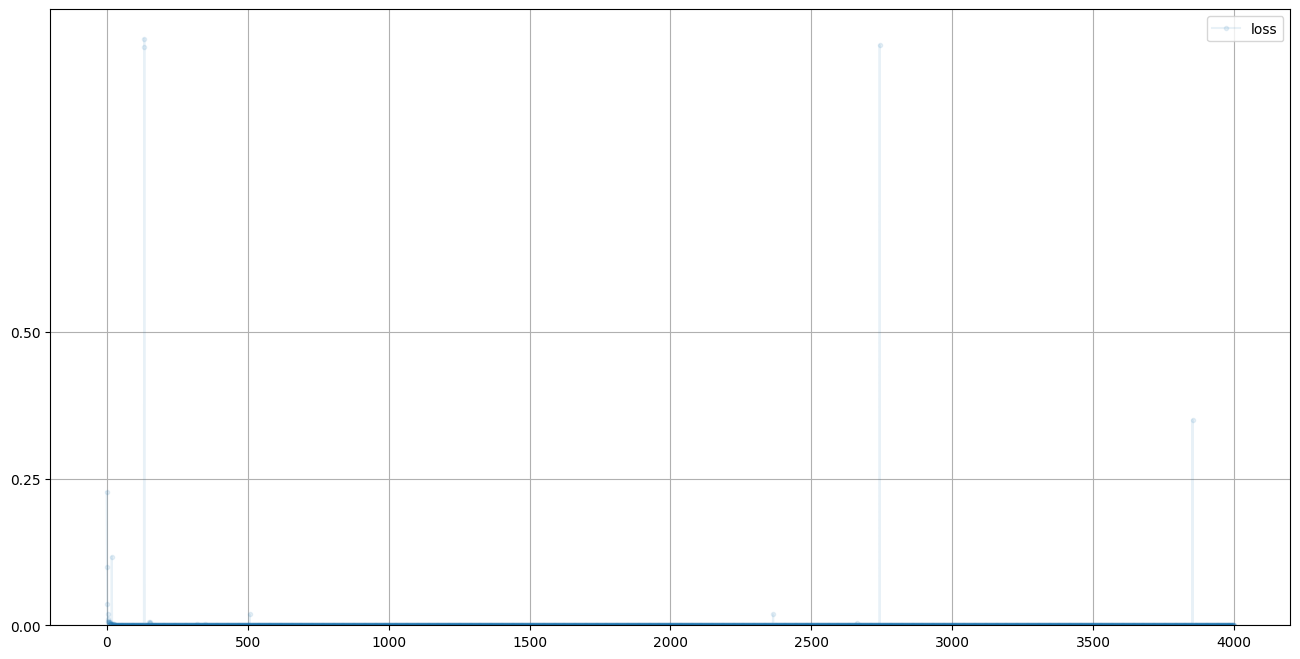

In [23]:
D.plot_progress()

In [24]:
import random
for i in range(4):
    image_data_tensor = celeba_dataset[random.randint(0, len(celeba_dataset))]
    print(D.forward(image_data_tensor).item())

for i in range(4):
    print(D.forward(generate_random_image((1, 3, 128, 128))).item())


1.0
1.0
1.0
1.0
1.7096607507482986e-06
1.0014666713686893e-06
0.00016396188584621996
0.00011564739543246105


In [25]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()

        # define the network
        self.model = nn.Sequential(
            nn.Linear(100, 3*11*11),
            nn.LeakyReLU(0.2),

            View((1, 3, 11, 11)),

            nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(3),

            nn.Sigmoid()
        )

        # define the optimiser
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # define the counter
        self.count = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, D, inputs, targets):
        g_outputs = self.forward(inputs)

        d_outputs = D.forward(g_outputs)

        loss = D.loss_function(d_outputs, targets)

        self.count += 1

        if self.count % 10 == 0:
            self.progress.append(loss.item())

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.8))


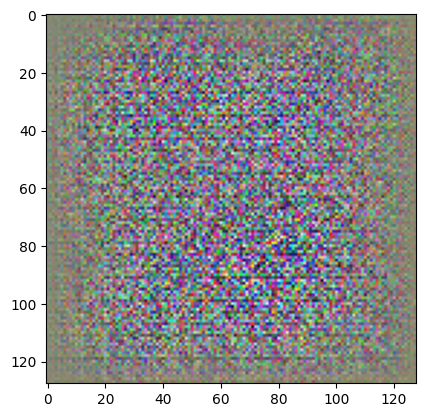

In [31]:
G = Generator()
G.to(device)


output = G.forward(generate_random_seed(100))
image = output.detach().permute(0, 2, 3, 1).view(128, 128, 3).cpu().numpy()
plt.imshow(image)

In [43]:
D = Discriminator()
D.to(device)

G = Generator()
G.to(device)

epochs = 3

for epoch in range(epochs):
    print("epoch = ", epoch)
    for image_tensor_data in celeba_dataset:
        # train discriminator on real image
        D.train(image_tensor_data, torch.cuda.FloatTensor([1.0]))
        # train discriminator on fake image
        D.train(G.forward(generate_random_seed(100).detach()), torch.cuda.FloatTensor([0.0]))
        # train generator
        G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

epoch =  0
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
epoch =  1
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
c

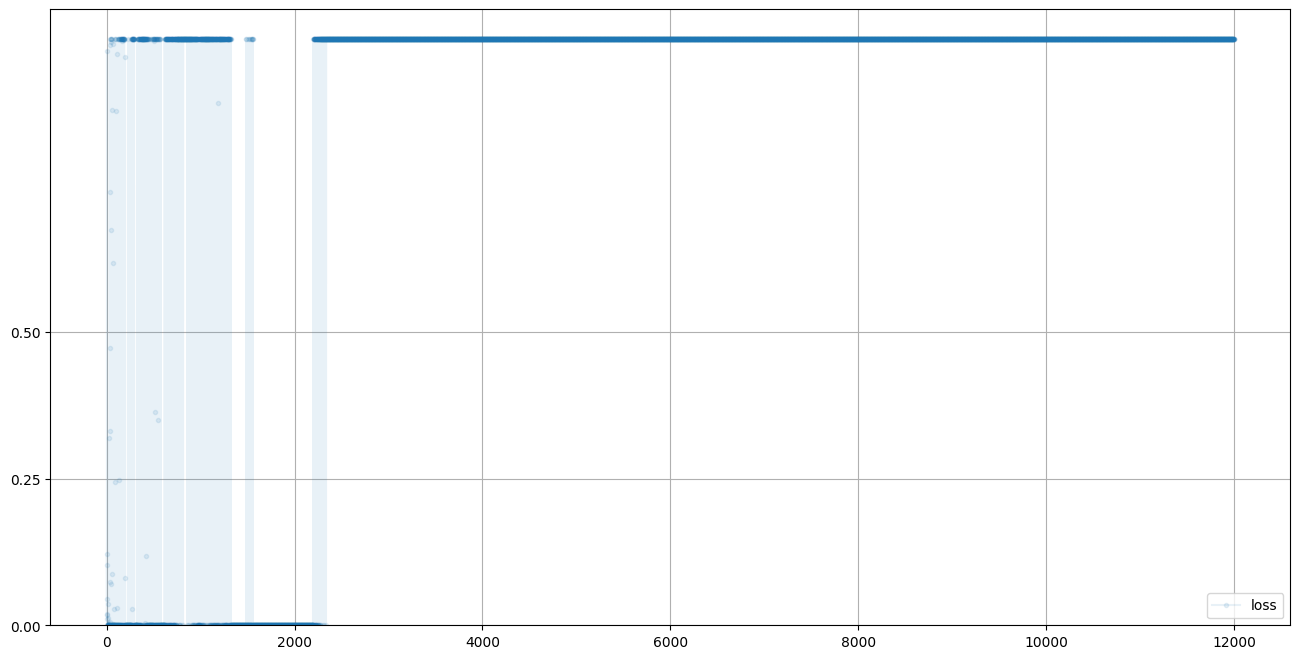

In [44]:
D.plot_progress()

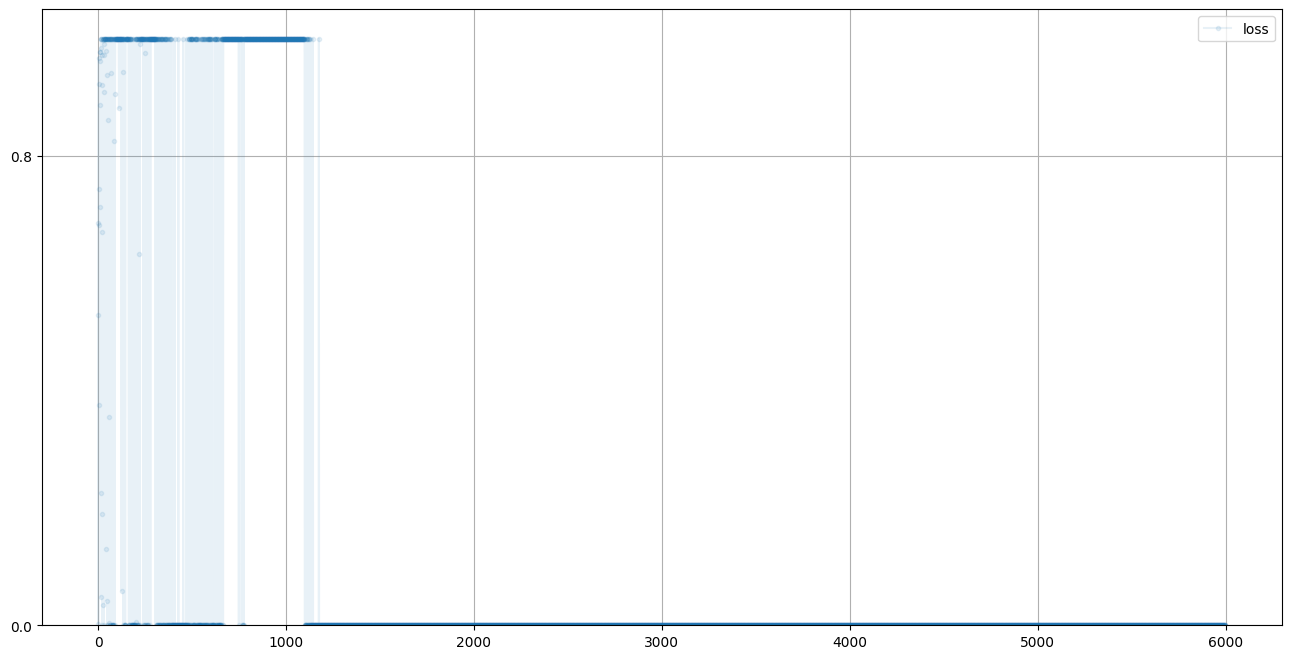

In [45]:
G.plot_progress()

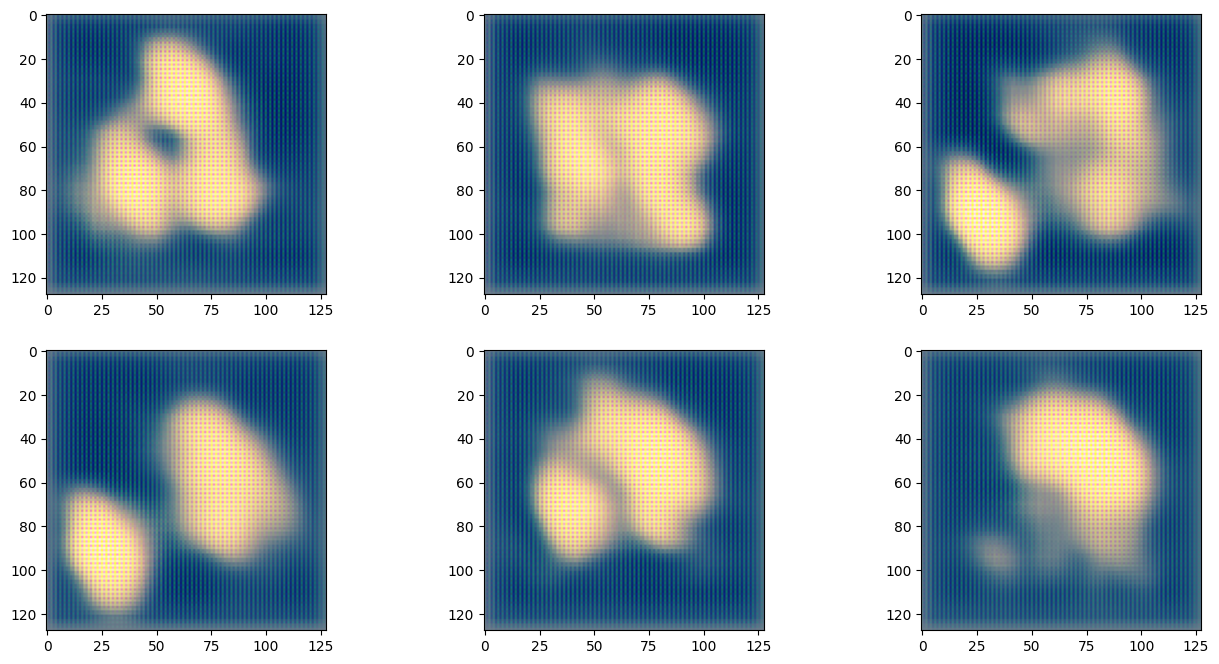

In [46]:
f, axarr = plt.subplots(2, 3, figsize=(16, 8))
for i in range(2):
    for j in range(3):
        axarr[i, j].imshow(
                G.forward(
                    generate_random_seed(100))
                    .detach()
                    .permute(0, 2, 3, 1)
                    .view(128, 128, 3)
                    .cpu()
                    .numpy()
            )
        